# Imports

In [0]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dropout, LSTM, Activation
from keras.layers import Input, Bidirectional,TimeDistributed
from keras.utils import to_categorical

import pickle

import os

from collections import Counter
from scipy.sparse import hstack

from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

# Read train.csv

In [78]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/IRE_Major_Project/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data = pd.read_csv(root_path+'preprocessed.csv')

In [80]:
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_a,subtask_b,subtask_c,original_tweet_length,new_tweet_length
0,86426,@USER She should ask a few native Americans wh...,she ask native americans their take be,1,0,0,0,OFF,UNT,NaN,14,7
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home you drink maga trump2020,3,2,1,1,OFF,TIN,IND,11,6
2,16820,Amazon is investigating Chinese employees who ...,amazon investigate chinese employees sell inte...,0,5,1,0,NOT,NaN,NaN,27,19
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,OFF,UNT,NaN,11,6
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama want liberals amp illegals move red state,2,0,0,0,NOT,NaN,NaN,12,8


# Splitting Data: Train and Test


In [81]:
data = data[data['subtask_c'].isin(['IND'  , 'GRP' , 'OTH'])]
data.drop(columns=['subtask_a' , 'subtask_b'] , inplace = True)
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_c,original_tweet_length,new_tweet_length
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home you drink maga trump2020,3,2,1,1,IND,11,6
5,97670,@USER Liberals are all Kookoo !!!,liberals kookoo,1,0,0,0,OTH,6,2
7,52415,@USER was literally just talking about this lo...,literally talk lol mass shoot like set up it p...,1,0,0,0,GRP,31,19
9,13384,@USER Canada doesn’t need another CUCK! We alr...,canada not need another cuck we already enough...,1,4,0,0,IND,19,17
12,28414,@USER you are a lying corrupt traitor!!! Nobod...,you lie corrupt traitor nobody want hear anymo...,1,1,1,0,IND,17,11


In [82]:
# data['subtask_a'].value_counts()
data['subtask_c'].value_counts()

IND    2407
GRP    1074
OTH     395
Name: subtask_c, dtype: int64

In [83]:
Y = data['subtask_c']
X = data.drop(['subtask_c','id'],axis=1)
print("Shape of X: ",X.shape)
print("Shape of Y: ",Y.shape)

Shape of X:  (3876, 8)
Shape of Y:  (3876,)


In [84]:
#separating data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.30,stratify=Y, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ",Y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of Y_test: ",Y_test.shape)

Shape of X_train:  (2713, 8)
Shape of Y_train:  (2713,)
Shape of X_test:  (1163, 8)
Shape of Y_test:  (1163,)


#### Change the mapping of the label column to binary


In [0]:
Y_train = Y_train.map(dict(IND=0, GRP=1 , OTH= 2))
Y_test = Y_test.map(dict(IND=0, GRP=1 , OTH = 2))

In [0]:
# ## one hot encode y for multiclass  classification 
# from sklearn.preprocessing import label_binarize


# Y_train = label_binarize(Y_train, classes=[0, 1, 2])
# Y_test = label_binarize(Y_test, classes=[0, 1, 2])

In [87]:
print(Y_train.shape)

(2713,)


# Making Data Model Ready: Encoding Tweets using GloVe Vectors (Pre-trained)


In [0]:
def get_embedding_matrix(tokenizer,vocab_size):
  '''
  Takes input a tokenizer trained on the training set and vocabulary size
  
  Returns glove vector encoding for each word in the vocabulary (300 dim)
  as embedding_matrix.
  '''

  with open(root_path+'glove_vectors', 'rb') as f:
      model = pickle.load(f)
      glove_words =  set(model.keys())

  embedding_matrix = np.zeros((vocab_size, 300))
  cnt=0
  for word, i in tokenizer.word_index.items():
    if word in glove_words:
      embedding_matrix[i] = model[word]
  return embedding_matrix

In [89]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['new_tweet'])
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: ",vocab_size)

Vocabulary size:  6633


In [0]:
embedding_matrix_train = get_embedding_matrix(tokenizer,vocab_size)

In [91]:
print("Size of embedding matrix to be fed to RNN: ", embedding_matrix_train.shape)

Size of embedding matrix to be fed to RNN:  (6633, 300)


In [0]:
encoded_tweets_train = tokenizer.texts_to_sequences(X_train['new_tweet'])
encoded_tweets_test = tokenizer.texts_to_sequences(X_test['new_tweet'])

In [0]:
padded_tweets_train = pad_sequences(encoded_tweets_train,maxlen=100)
padded_tweets_test = pad_sequences(encoded_tweets_test,maxlen=100)

In [94]:
print("After padding train and test tweets: ")
print("padded train data:",padded_tweets_train.shape)
print("padded test data,", padded_tweets_test.shape)

After padding train and test tweets: 
padded train data: (2713, 100)
padded test data, (1163, 100)


#LSTM


In [95]:
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix_train], input_length=100, trainable=False)
model.add(e)
model.add(LSTM(20))
model.add(Dropout(0.6))
model.add(Dense(3, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          1989900   
_________________________________________________________________
lstm_7 (LSTM)                (None, 20)                25680     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 63        
Total params: 2,015,643
Trainable params: 25,743
Non-trainable params: 1,989,900
_________________________________________________________________
None


In [96]:
print(Y_train.values.shape)
print(set(Y_train.values))
train_labels = to_categorical(Y_train.values)
print(train_labels.shape)
test_labels = to_categorical(Y_test.values)
print(test_labels.shape)

(2713,)
{0, 1, 2}
(2713, 3)
(1163, 3)


In [97]:
# fit the model
model.fit(padded_tweets_train, train_labels, epochs=50)
# evaluate the model
loss, accuracy = model.evaluate(padded_tweets_train, train_labels)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/50
2713/2713 [==============================] - 13s 5ms/step - loss: 0.9468 - acc: 0.5754
Epoch 2/50
1696/2713 [=================>............] - ETA: 4s - loss: 0.8419 - acc: 0.6303

KeyboardInterrupt: ignored

In [0]:
y_pred = model.predict(padded_tweets_test, batch_size=1)

In [0]:
print(len(y_pred))
print(y_pred)

In [0]:
y_pred_bool = np.argmax(y_pred,axis=1)

In [0]:
print(len(y_pred_bool))
print(y_pred_bool)

In [0]:
print(classification_report(Y_test.values, y_pred_bool))
results = confusion_matrix(Y_test.values, y_pred_bool)
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [0]:
f1_score(Y_test.values,  y_pred_bool, average='weighted')  

#Biderectional LSTM

## Model creating

In [0]:
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix_train], input_length=100, trainable=False)
model.add(e)
model.add(Bidirectional(LSTM(40, return_sequences=True)))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(16, activation='tanh'))

model.add(Dense(3, activation='softmax'))
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [99]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 300)          1989900   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100, 80)           109120    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 20)                7280      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                336       
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 51        
Total params: 2,106,687
Trainable params: 116,787
Non-trainable params: 1,989,900
_________________________________________________________________
None


## Train model

In [100]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train), Y_train)
print(class_weights)

[0.53669634 1.20257092 3.27657005]


In [101]:
# fit the model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# model.fit(padded_tweets_train, train_labels, epochs=50)
history = model.fit(padded_tweets_train, train_labels, epochs=15,class_weight=class_weights)

Epoch 1/15
2713/2713 [==============================] - 50s 18ms/step - loss: 0.8306 - acc: 0.6329
Epoch 2/15
2713/2713 [==============================] - 46s 17ms/step - loss: 0.7412 - acc: 0.6830
Epoch 3/15
2713/2713 [==============================] - 46s 17ms/step - loss: 0.7018 - acc: 0.7044
Epoch 4/15
2713/2713 [==============================] - 46s 17ms/step - loss: 0.6644 - acc: 0.7302
Epoch 5/15
2713/2713 [==============================] - 47s 17ms/step - loss: 0.6267 - acc: 0.7482
Epoch 6/15
2713/2713 [==============================] - 47s 17ms/step - loss: 0.5768 - acc: 0.7733
Epoch 7/15
2713/2713 [==============================] - 47s 17ms/step - loss: 0.5069 - acc: 0.8024
Epoch 8/15
2713/2713 [==============================] - 46s 17ms/step - loss: 0.4517 - acc: 0.8264
Epoch 9/15
2713/2713 [==============================] - 46s 17ms/step - loss: 0.3750 - acc: 0.8588
Epoch 10/15
2713/2713 [==============================] - 46s 17ms/step - loss: 0.3098 - acc: 0.8916
Epoch 11/

In [0]:
# loss, accuracy = model.evaluate(padded_tweets_train, Y_train.values)
loss, accuracy = model.evaluate(padded_tweets_train, train_labels)
print('Accuracy: %f' % (accuracy*100))
# print(train_labels,Y_train)

1632/2713 [=================>............] - ETA: 8s

KeyboardInterrupt: ignored

## Predict using the model

In [0]:
y_pred = model.predict(padded_tweets_test, batch_size=1)
predicted_labels = np.argmax(y_pred,axis=1)

In [103]:
print(y_pred)

[[9.9666983e-01 2.7238534e-04 3.0577714e-03]
 [9.9702185e-01 2.3950210e-03 5.8314687e-04]
 [8.4560835e-01 5.6888033e-02 9.7503662e-02]
 ...
 [9.9818653e-01 7.5920171e-04 1.0543377e-03]
 [8.9934385e-01 1.4127010e-03 9.9243432e-02]
 [9.9773288e-01 1.3268816e-03 9.4019773e-04]]


              precision    recall  f1-score   support

           0       0.74      0.78      0.76       722
           1       0.51      0.42      0.46       322
           2       0.17      0.19      0.18       119

    accuracy                           0.62      1163
   macro avg       0.47      0.46      0.47      1163
weighted avg       0.62      0.62      0.62      1163



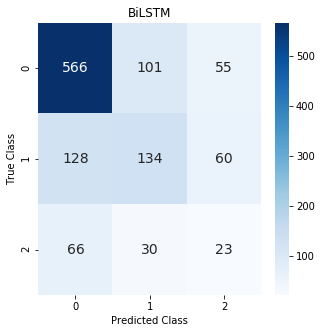

In [104]:
# y_pred_bool = [convert_prob_to_label(p) for p in y_pred]
print(classification_report(Y_test.values, predicted_labels))
results = confusion_matrix(Y_test.values, predicted_labels)
# print(classification_report(Y_test.values, y_pred_bool))
# results = confusion_matrix(Y_test.values, y_pred_bool)
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('BiLSTM')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [107]:
print("F1 Score = " + str(f1_score(Y_test.values,predicted_labels,average='micro')))

F1 Score = 0.6216680997420464


## Misclassifications

In [72]:
misclassified = np.where(Y_test.values != predicted_labels)
print(len(misclassified[0]), 'miclassifications')

361 miclassifications


In [0]:
def prRed(skk): print("\033[91m {}\033[00m" .format(skk)) 
def prGreen(skk): print("\033[92m {}\033[00m" .format(skk)) 
def prPurple(skk): print("\033[95m {}\033[00m" .format(skk)) 
def prCyan(skk): print("\033[96m {}\033[00m" .format(skk)) 
def prLighBlue(skk): print("\033[94m {}\033[00m" .format(skk)) 
def prOrange(skk): print("\033[33m {}\033[00m" .format(skk)) 

Red: original individual insult (0), classified as group (1)<br>
Green: original individual insult (0), classified as other (2)<br>
Purple: original group insult (1), classified as individual (0) <br>
Cyan: original group insult (1), classified as other (2)<br>
Light Blue: original other insult (2), classified as individual (0) <br>
Orange: original other insult (2), classified as group (1)

In [0]:
y_test = Y_test.values

In [0]:
def print_stuff(idx):
  global y_pred
  global X_test
  global y_test
  # preprocessed_tweet
  print('preprocessed tweet')
  print(X_test.iloc[idx,1])
  # computed prob
  print('computed prob: ',y_pred[idx])
  print('original class: ',y_test[idx])

In [76]:
#IND=0, GRP=1 , OTH= 2
counts = [0] * 6
limit=5

for index in misclassified[0]:
  if limit in counts:
    break
  #original individual insult (0), classified as group (1)
  if y_test[index] == 0 and predicted_labels[index] == 1:
    prRed(X_test.iloc[index,0])
    print_stuff(index)
    counts[0] += 1
  #original individual insult (0), classified as other (2)
  elif y_test[index] == 0 and predicted_labels[index] == 2:
    prGreen(X_test.iloc[index,0])
    print_stuff(index)
    counts[1] += 1
  #original group insult (1), classified as individual (0)
  elif y_test[index] == 1 and predicted_labels[index] == 0:
    prPurple(X_test.iloc[index,0])
    print_stuff(index)
    counts[2] += 1
  #original group insult (1), classified as other (2)
  elif y_test[index] == 1 and predicted_labels[index] == 2:
    prCyan(X_test.iloc[index,0])
    print_stuff(index)
    counts[3] += 1
  #original other insult (2), classified as individual (0)
  elif y_test[index] == 2 and predicted_labels[index] == 0:
    prLighBlue(X_test.iloc[index,0])
    print_stuff(index)
    counts[4] += 1
  #original other insult (2), classified as group (1)
  elif y_test[index] == 2 and predicted_labels[index] == 1:
    prOrange(X_test.iloc[index,0])
    print_stuff(index)
    counts[5] += 1

 @USER //xD Well the suffering she goes through and all the terrible shit she sees ends up making her pretty insane (I think you already seen that from certain things I posted XD) but hey at least she's only insane to bad guys!
preprocessed tweet
xd well suffer she go terrible shit she see end make her pretty insane i think you already see certain things i post xd hey least she s insane bad guy
computed prob:  [0.96078986 0.01636781 0.02284227]
original class:  1
 @USER @USER @USER Oh and higher unemployment and witch hunts and lynch mobs and antifa communist parades ...you can have all that shit and let Hollywood decide how you feel.
preprocessed tweet
oh higher unemployment witch hunt lynch mob antifa communist parade you shit let hollywood decide you feel
computed prob:  [0.8890367  0.06772081 0.04324247]
original class:  2
 @USER thanks Joe!!! my sanity was forsaken a looong time ago hahaha
preprocessed tweet
thank joe my sanity forsake looong time ago hahaha
computed prob:  [0.951